In [1]:
%run setup.ipynb
%matplotlib inline
%config InlineBackend.figure_formats = {'retina', 'png'}
rcParams['figure.dpi'] = 120

In [2]:
# setup callset - needed for variant annotations
callset_pass = phase1_ar31.callset_pass
pos_pass = allel.SortedIndex(callset_pass['2L/variants/POS'])
ann_pass = callset_pass['2L/variants/ANN'][:][['Annotation', 'HGVS_p']]

In [3]:
# setup haplotypes
callset_phased = phase1_ar31.callset_phased
genotypes_phased = allel.GenotypeChunkedArray(callset_phased['2L/calldata/genotype'])
pos_phased = allel.SortedIndex(callset_phased['2L/variants/POS'])
ref_phased = callset_phased['2L/variants/REF']
alt_phased = callset_phased['2L/variants/ALT']

In [4]:
# for reference, where are the kdr mutations again?
loc_kdr_pass = pos_pass.locate_range(2422600, 2422670)
loc_kdr_pass, ann_pass[loc_kdr_pass], pos_pass[loc_kdr_pass]

(slice(26668, 26670, None), array([(b'missense_variant', b'p.Leu995Ser'),
        (b'missense_variant', b'p.Leu995Phe')], 
       dtype=[('Annotation', 'S34'), ('HGVS_p', 'S14')]), <SortedIndex shape=(2,) dtype=int32>
 [2422651, 2422652])

In [5]:
pos_995S = 2422651
pos_995F = 2422652

In [6]:
# define ascertainment for EHH analysis
loc_region = pos_phased.locate_range(0, 4000000)
pos_phased_region = pos_phased[loc_region]
ref_phased_region = ref_phased[loc_region]
alt_phased_region = alt_phased[loc_region]
pos_phased_region

0,1,2,3,4,...,163958,163959,163960,163961,163962
44688,44691,44732,44736,44756,...,3997372,3997373,3997378,3997381,3997386


In [7]:
# locate the kdr variants within the haplotypes callset
idx_995S = pos_phased_region.locate_key(pos_995S)
idx_995F = pos_phased_region.locate_key(pos_995F)
idx_995S, idx_995F

(26000, 26001)

In [8]:
# locate the intersection - needed to tie in annotations
loc1, _ = pos_pass.locate_intersection(pos_phased_region)
np.count_nonzero(loc1)

163963

In [9]:
ann_phased_region = ann_pass[loc1]
ann_phased_region

array([(b'intergenic_region', b'.'), (b'intergenic_region', b'.'),
       (b'intergenic_region', b'.'), ...,
       (b'downstream_gene_variant', b'.'),
       (b'downstream_gene_variant', b'.'),
       (b'downstream_gene_variant', b'.')], 
      dtype=[('Annotation', 'S34'), ('HGVS_p', 'S14')])

In [10]:
collections.Counter(ann_phased_region['Annotation'])

Counter({b'3_prime_UTR_variant': 2941,
         b'5_prime_UTR_premature_start_codon_': 306,
         b'5_prime_UTR_variant': 1677,
         b'downstream_gene_variant': 18539,
         b'initiator_codon_variant': 3,
         b'intergenic_region': 54849,
         b'intragenic_variant': 48,
         b'intron_variant': 32362,
         b'missense_variant': 5805,
         b'missense_variant&splice_region_var': 70,
         b'splice_acceptor_variant&intron_var': 24,
         b'splice_donor_variant&intron_varian': 27,
         b'splice_region_variant': 36,
         b'splice_region_variant&intron_varia': 649,
         b'splice_region_variant&stop_retaine': 5,
         b'splice_region_variant&synonymous_v': 87,
         b'start_lost': 9,
         b'stop_gained': 37,
         b'stop_lost&splice_region_variant': 4,
         b'stop_retained_variant': 5,
         b'synonymous_variant': 8636,
         b'upstream_gene_variant': 37844})

In [11]:
# exclude cross parents
haps_phased_region = genotypes_phased[loc_region].to_haplotypes()[:, :-16]
haps_phased_region

<HaplotypeArray shape=(163963, 1530) dtype=int8>
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
...
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0

In [12]:
loc_haps_995S = haps_phased_region[idx_995S] == 1
np.count_nonzero(loc_haps_995S)

430

In [13]:
loc_haps_995F = haps_phased_region[idx_995F] == 1
np.count_nonzero(loc_haps_995F)

775

In [14]:
loc_haps_wt = ~loc_haps_995S & ~loc_haps_995F
np.count_nonzero(loc_haps_wt)

325

In [15]:
ac_phased_region = haps_phased_region.count_alleles(max_allele=1)
ac_phased_region

<AlleleCountsArray shape=(163963, 2) dtype=int32>
1529    1
1528    2
1528    2
...
1527    3
1529    1
1527    3

In [16]:
# define types of variants to include in EHH analysis - should be mostly neutral
loc_ehh_type = ((ann_phased_region['Annotation'] == b'intergenic_region') | 
                (ann_phased_region['Annotation'] == b'intron_variant') |
                (ann_phased_region['Annotation'] == b'downstream_gene_variant') |
                (ann_phased_region['Annotation'] == b'upstream_gene_variant') |
                (ann_phased_region['Annotation'] == b'synonymous_variant') |
                (ann_phased_region['Annotation'] == b'3_prime_UTR_variant') |
                (ann_phased_region['Annotation'] == b'5_prime_UTR_variant') 
               )
# patch in kdr
loc_ehh_type[idx_995S] = True
loc_ehh_type[idx_995F] = True
np.count_nonzero(loc_ehh_type), loc_ehh_type.shape

(156850, (163963,))

In [17]:
# locate singletons - will exclude from EHH analysis
loc_ehh_mac = ac_phased_region.min(axis=1) > 1
np.count_nonzero(loc_ehh_mac), loc_ehh_mac.shape

(111614, (163963,))

In [18]:
# these are the variants to use for EHH
loc_ehh = loc_ehh_type & loc_ehh_mac
np.count_nonzero(loc_ehh), loc_ehh.shape

(107535, (163963,))

In [19]:
haps_ehh = haps_phased_region[loc_ehh]
haps_ehh

<HaplotypeArray shape=(107535, 1530) dtype=int8>
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
1 1 1 1 1 ... 1 1 1 1 1
...
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0

In [20]:
pos_ehh = pos_phased_region[loc_ehh]
ref_ehh = ref_phased_region[loc_ehh]
alt_ehh = alt_phased_region[loc_ehh]
pos_ehh

0,1,2,3,4,...,107530,107531,107532,107533,107534
44691,44732,44756,44767,44872,...,3997366,3997367,3997373,3997378,3997386


In [21]:
idx_995S_ehh = pos_ehh.locate_key(pos_995S)
idx_995F_ehh = pos_ehh.locate_key(pos_995F)
idx_995S_ehh, idx_995F_ehh

(15754, 15755)

In [22]:
# load in cluster membership obtained via distance clustering for comparison
cluster_membership = np.load('../data/vgsc_cluster_membership.npy').astype('U')
cluster_membership[cluster_membership == ''] = 'wt'
cluster_membership

array(['F1', 'F1', 'wt', ..., 'F1', 'F1', 'F1'], 
      dtype='<U2')

In [23]:
cluster_indices = {l: set(np.nonzero(cluster_membership == l)[0]) for l in np.unique(cluster_membership)}
cluster_indices['F2']

{781, 857, 910, 961, 963, 985, 1033, 1085, 1125, 1140, 1173, 1182, 1192, 1226}

In [24]:
# read in haplotype metadata to get population
df_haplotypes = phase1_ar31.df_haplotypes
df_haplotypes = df_haplotypes[df_haplotypes.population != 'colony']
df_haplotypes.head()

,label,ox_code,population,label_aug,country,region,sex,m_s,kt_2la,kt_2rb
index,,,,,,,,,,
0,AB0085-Ca,AB0085-C,BFS,"AB0085-Ca [Burkina Faso, Pala, S, F]",Burkina Faso,Pala,F,S,2.0,2.0
1,AB0085-Cb,AB0085-C,BFS,"AB0085-Cb [Burkina Faso, Pala, S, F]",Burkina Faso,Pala,F,S,2.0,2.0
2,AB0087-Ca,AB0087-C,BFM,"AB0087-Ca [Burkina Faso, Bana, M, F]",Burkina Faso,Bana,F,M,2.0,1.0
3,AB0087-Cb,AB0087-C,BFM,"AB0087-Cb [Burkina Faso, Bana, M, F]",Burkina Faso,Bana,F,M,2.0,1.0
4,AB0088-Ca,AB0088-C,BFM,"AB0088-Ca [Burkina Faso, Bana, M, F]",Burkina Faso,Bana,F,M,2.0,0.0


In [25]:
# centre on KDR
pos_left = pos_ehh[0:idx_995F_ehh+1]
pos_left

0,1,2,3,4,...,15751,15752,15753,15754,15755
44691,44732,44756,44767,44872,...,2422382,2422402,2422544,2422651,2422652


In [26]:
haps_left = haps_ehh[0:idx_995F_ehh+1]

In [27]:
pos_right = pos_ehh[idx_995S_ehh:]
pos_right

0,1,2,3,4,...,91776,91777,91778,91779,91780
2422651,2422652,2422697,2422907,2422910,...,3997366,3997367,3997373,3997378,3997386


In [28]:
haps_right = haps_ehh[idx_995S_ehh:]

In [29]:
# copy this out of scikit-allel because of a bug

def voight_painting(h):
    """Paint haplotypes, assigning a unique integer to each shared haplotype
    prefix.

    Parameters
    ----------
    h : array_like, int, shape (n_variants, n_haplotypes)
        Haplotype array.

    Returns
    -------
    painting : ndarray, int, shape (n_variants, n_haplotypes)
        Painting array.
    indices : ndarray, int, shape (n_hapotypes,)
        Haplotype indices after sorting by prefix.

    """

    # check inputs
    # N.B., ensure int8 so we can use cython optimisation
    h = allel.HaplotypeArray(h, dtype='i1', copy=False)
    if h.max() > 1:
        raise NotImplementedError('only biallelic variants are supported')
    if h.min() < 0:
        raise NotImplementedError('missing calls are not supported')

    # sort by prefix
    indices = h.prefix_argsort()
    h = np.take(h, indices, axis=1)

    # paint
    painting = allel.opt.stats.paint_shared_prefixes(np.asarray(h))

    return painting, indices

In [30]:
kdr_palette = sns.color_palette('hls', n_colors=10)
kdr_colors = {
    'wt': 'w',
    'F1': kdr_palette[0],
    'F2': kdr_palette[1],
    'F3': kdr_palette[2],
    'F4': kdr_palette[3],
    'F5': kdr_palette[4],
    'S1': kdr_palette[5],
    'S2': kdr_palette[6],
    'S3': kdr_palette[7],
    'S4': kdr_palette[8],
    'S5': kdr_palette[9],
}

In [31]:
def analyze_haplotype_sharing(h, pos, spd_cut=10000, min_clust_count=12, no_snps=100):

    pntg, pntg_idx = voight_painting(h)

    h_pfxsrt = h[:, pntg_idx]
    h_pfxsrt

    spl = allel.opt.stats.neighbour_shared_prefix_lengths(np.asarray(h_pfxsrt))
    plt.hist(spl, bins=20);

    # shared prefix distance
    spd = np.zeros_like(spl)
    for i, l in enumerate(spl):
        spd[i] = math.fabs(pos[l-1] - pos[0])

    clst_pfxsrt = cluster_membership[pntg_idx]
    clst_pfxsrt

    fig, ax = plt.subplots(figsize=(14, 8))
    sns.despine(ax=ax, offset=5)
    x = np.arange(h.shape[1]-1) + .5
    ax.plot(x, spd, color='k')
    ax.set_xlabel('Haplotypes')
    ax.set_ylabel('Shared haplotype length (bp)')
    ax.set_title('Haplotype homozygosity')
    ax.set_yscale('log')
    ax.set_ylim(10**2, 1.6*10**6)
    ax.set_xlim(0, h.shape[1])
    clst_colors = [kdr_colors[k] for k in clst_pfxsrt]
    ax.broken_barh(xranges=[(t, 1) for t in range(h.shape[1])], yrange=(1, spd_cut), facecolors=clst_colors, zorder=-10)
    handles = [mpl.patches.Patch(facecolor=v, edgecolor='k', label=k) for k, v in sorted(kdr_colors.items())]
    ax.legend(handles=handles, bbox_to_anchor=(1, 1), loc='upper left')
    for i, d in enumerate(spd):
        if i > 0 and i < spd.shape[0] - 1 and d < spd_cut:
            if d < spd[i-1] and l < spd[i+1]:
                ax.text(i+.5, max(d, 10**2), str(d), transform=ax.transData)
    fig.tight_layout();

    fig, ax = plt.subplots(figsize=(14, 8))
    sns.despine(ax=ax, offset=5)
    x = np.arange(h.shape[1]-1) + .5
    ax.plot(x, spl, color='k')
    ax.set_xlabel('Haplotypes')
    ax.set_ylabel('Shared haplotype length (No. SNPs)')
    ax.set_title('Haplotype homozygosity')
    ax.set_xlim(0, h.shape[1])
    clst_colors = [kdr_colors[k] for k in clst_pfxsrt]
    ax.broken_barh(xranges=[(t, 1) for t in range(h.shape[1])], yrange=(0, no_snps), facecolors=clst_colors, zorder=-20)
    handles = [mpl.patches.Patch(facecolor=v, edgecolor='k', label=k) for k, v in sorted(kdr_colors.items())]
    ax.legend(handles=handles, bbox_to_anchor=(1, 1), loc='upper left')
    ax.set_ylim(0, no_snps)
    ax.grid(axis='y')
    for i, l in enumerate(spl):
        if i > 0 and i < spl.shape[0] - 1 and l < no_snps:
            if l < spl[i-1] and l < spl[i+1]:
                ax.text(i+.5, l, str(l), transform=ax.transData)
    fig.tight_layout();

    spd_clusters = list()
    cur = set()
    for i in range(len(pntg_idx)):
        idx = pntg_idx[i]
        cur.add(idx)
        if i < spd.shape[0]:
            d = spd[i]
            if d < spd_cut:
                spd_clusters.append(cur)
                cur = set()
    for s in spd_clusters: 
        if len(s) >= min_clust_count:
            sc = collections.Counter(cluster_membership[list(s)]).most_common()
            c = sc[0][0]
            overlap = len(cluster_indices[c].intersection(s))
            n = len(cluster_indices[c])
            print('%s %s/%s (%.1f%%)' % (c, overlap, n, overlap * 100 / n), sc)

wt 16/337 (4.7%) [('wt', 16)]
wt 11/337 (3.3%) [('wt', 11), ('F1', 7)]
wt 26/337 (7.7%) [('wt', 26), ('F5', 2), ('F3', 2), ('F4', 2)]
wt 29/337 (8.6%) [('wt', 29), ('F5', 2), ('F3', 1), ('F1', 1)]
wt 11/337 (3.3%) [('wt', 11), ('F1', 2), ('S5', 1)]
wt 16/337 (4.7%) [('wt', 16), ('S4', 1)]
wt 17/337 (5.0%) [('wt', 17)]
F5 167/194 (86.1%) [('F5', 167), ('wt', 10), ('S2', 3), ('F3', 2), ('S5', 2), ('F4', 2), ('S4', 1)]
F2 13/14 (92.9%) [('F2', 13), ('wt', 1)]
F4 28/42 (66.7%) [('F4', 28), ('wt', 3), ('F5', 2), ('F1', 2), ('F3', 1)]
F3 45/53 (84.9%) [('F3', 45), ('wt', 3), ('F5', 2), ('F4', 1)]
F1 445/465 (95.7%) [('F1', 445), ('wt', 14), ('S5', 2), ('F4', 2), ('F5', 1)]
S4 32/37 (86.5%) [('S4', 32), ('S5', 28), ('wt', 6), ('F5', 3), ('F1', 3)]
S1 101/108 (93.5%) [('S1', 101), ('S3', 7)]
S2 76/79 (96.2%) [('S2', 76), ('F5', 2)]
S3 12/165 (7.3%) [('S3', 12)]
S3 145/165 (87.9%) [('S3', 145), ('S1', 7)]


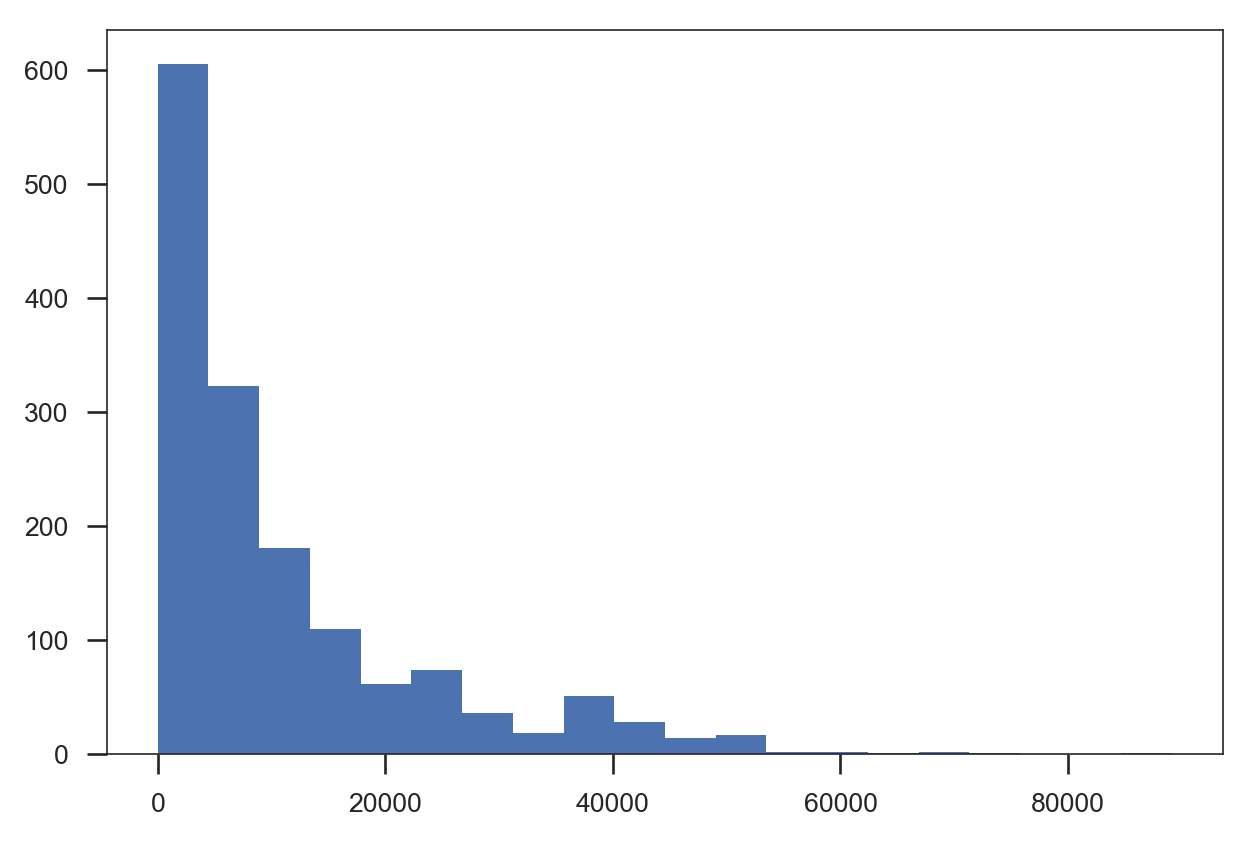

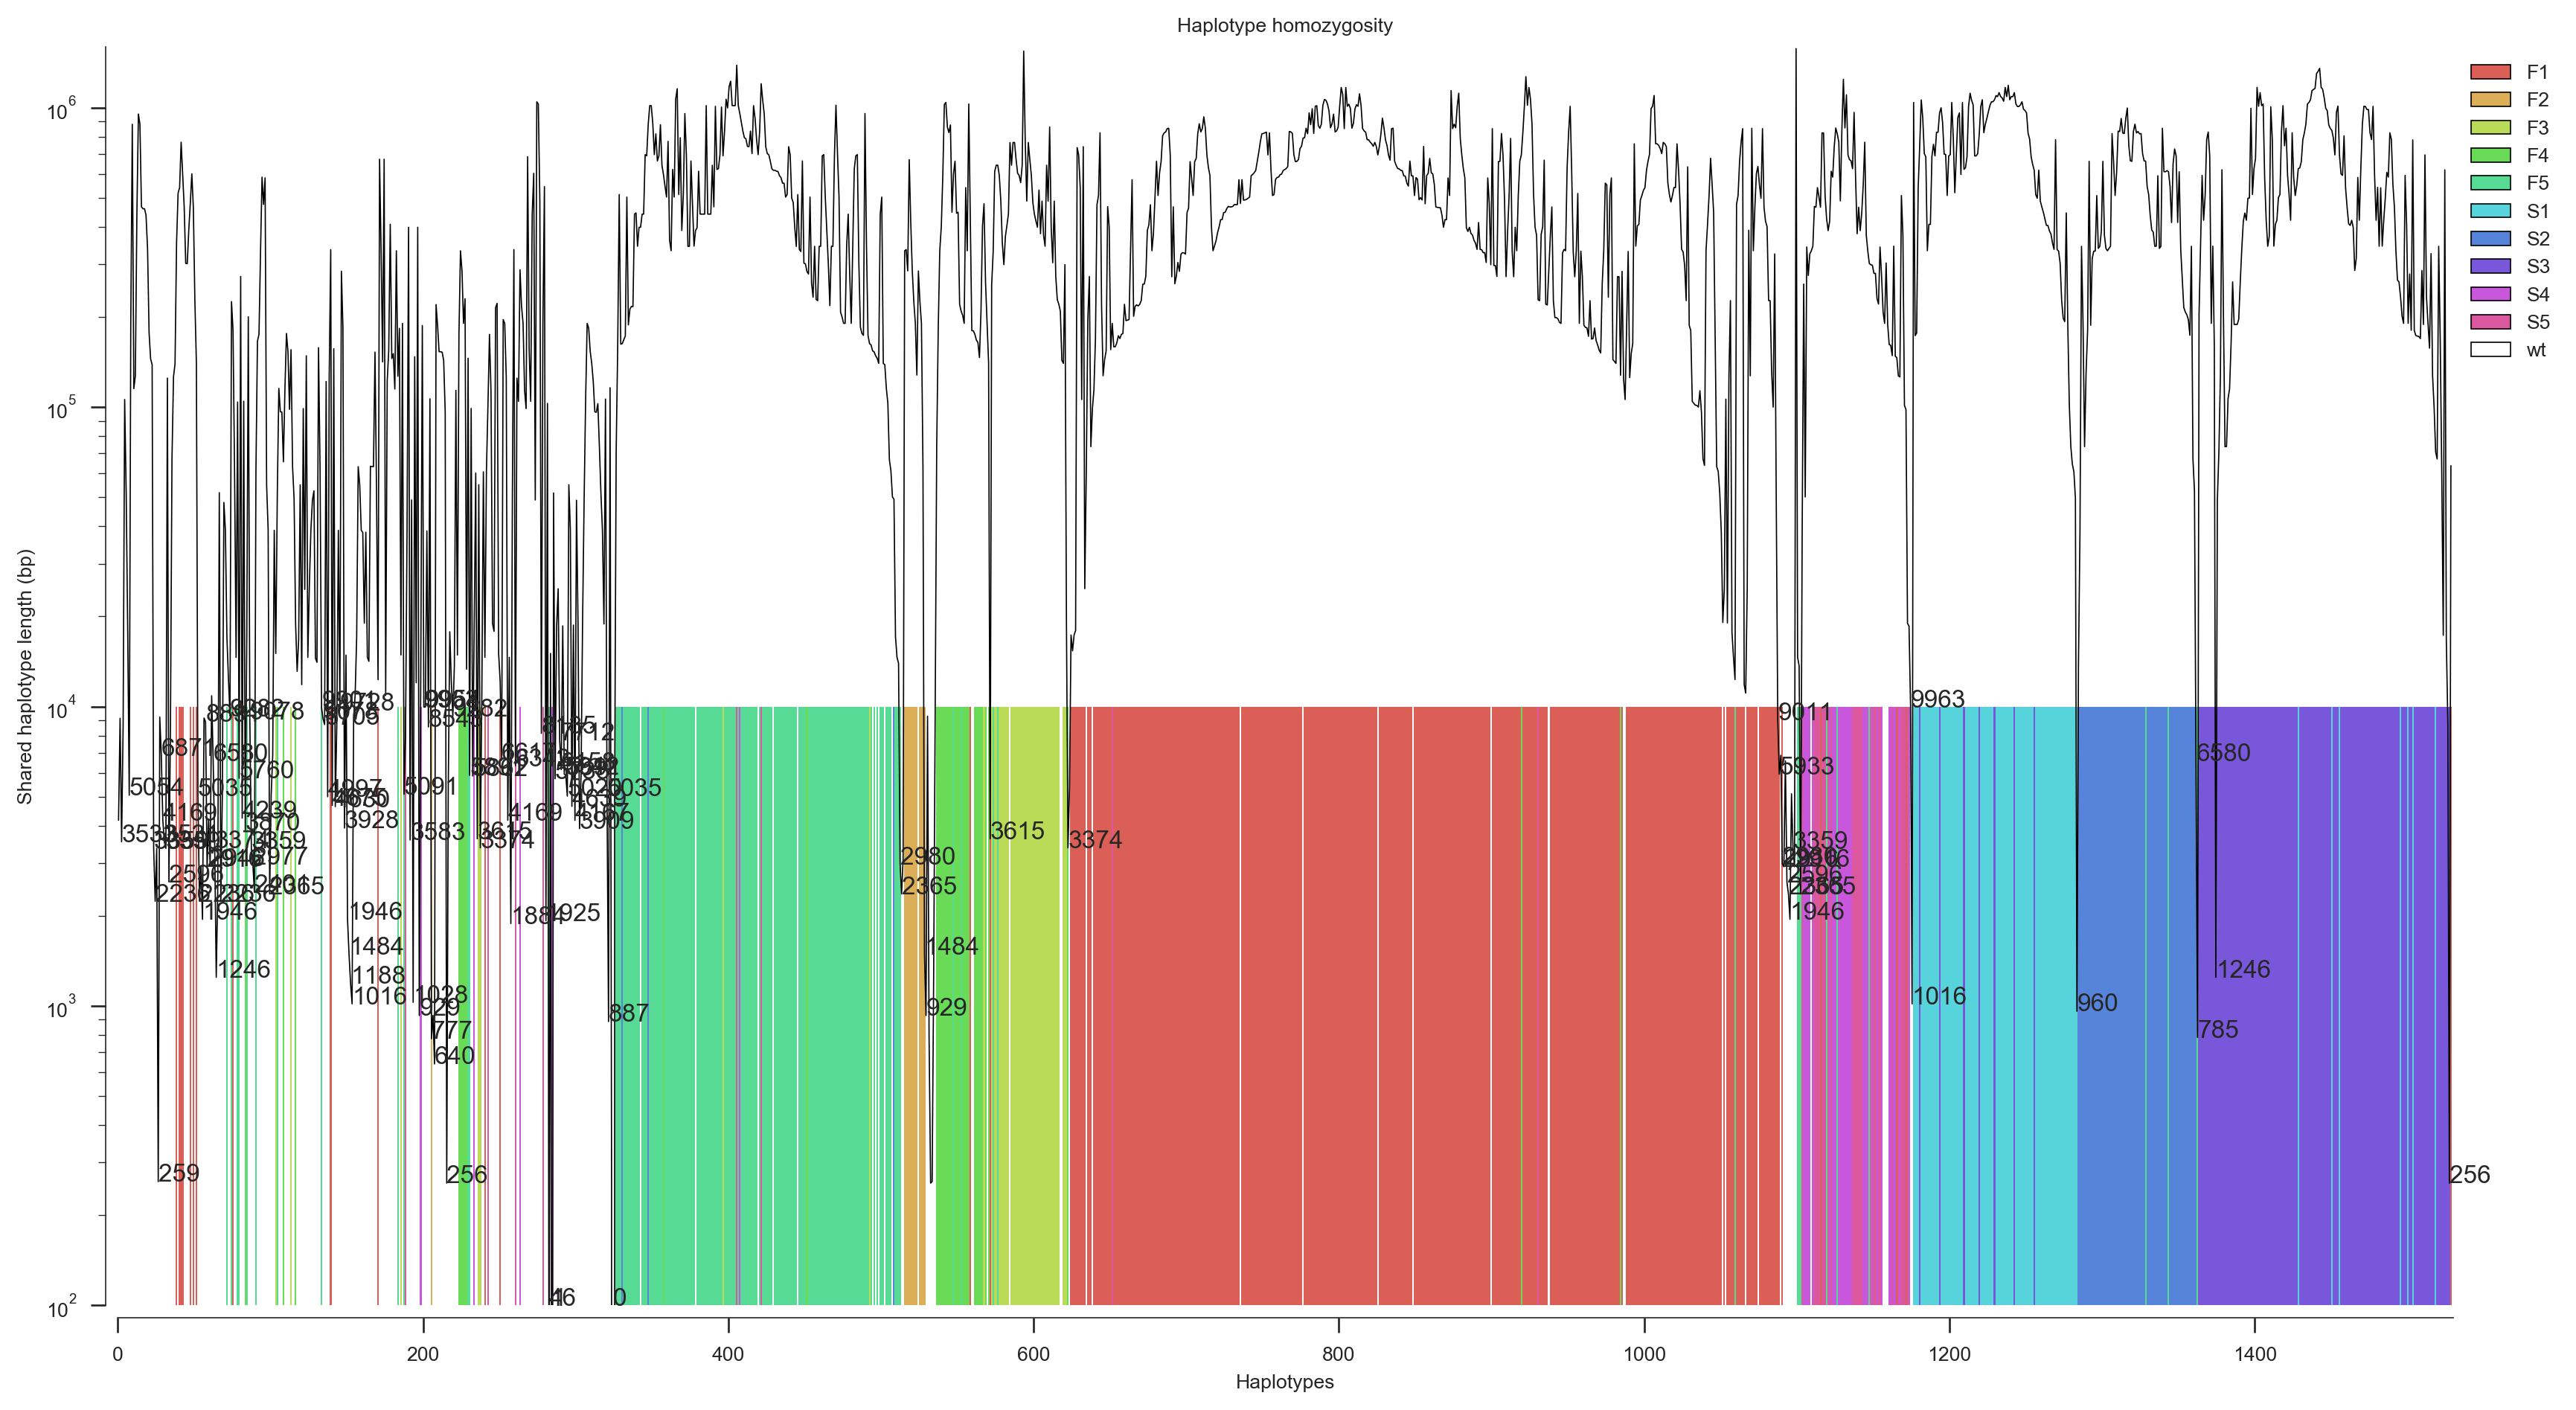

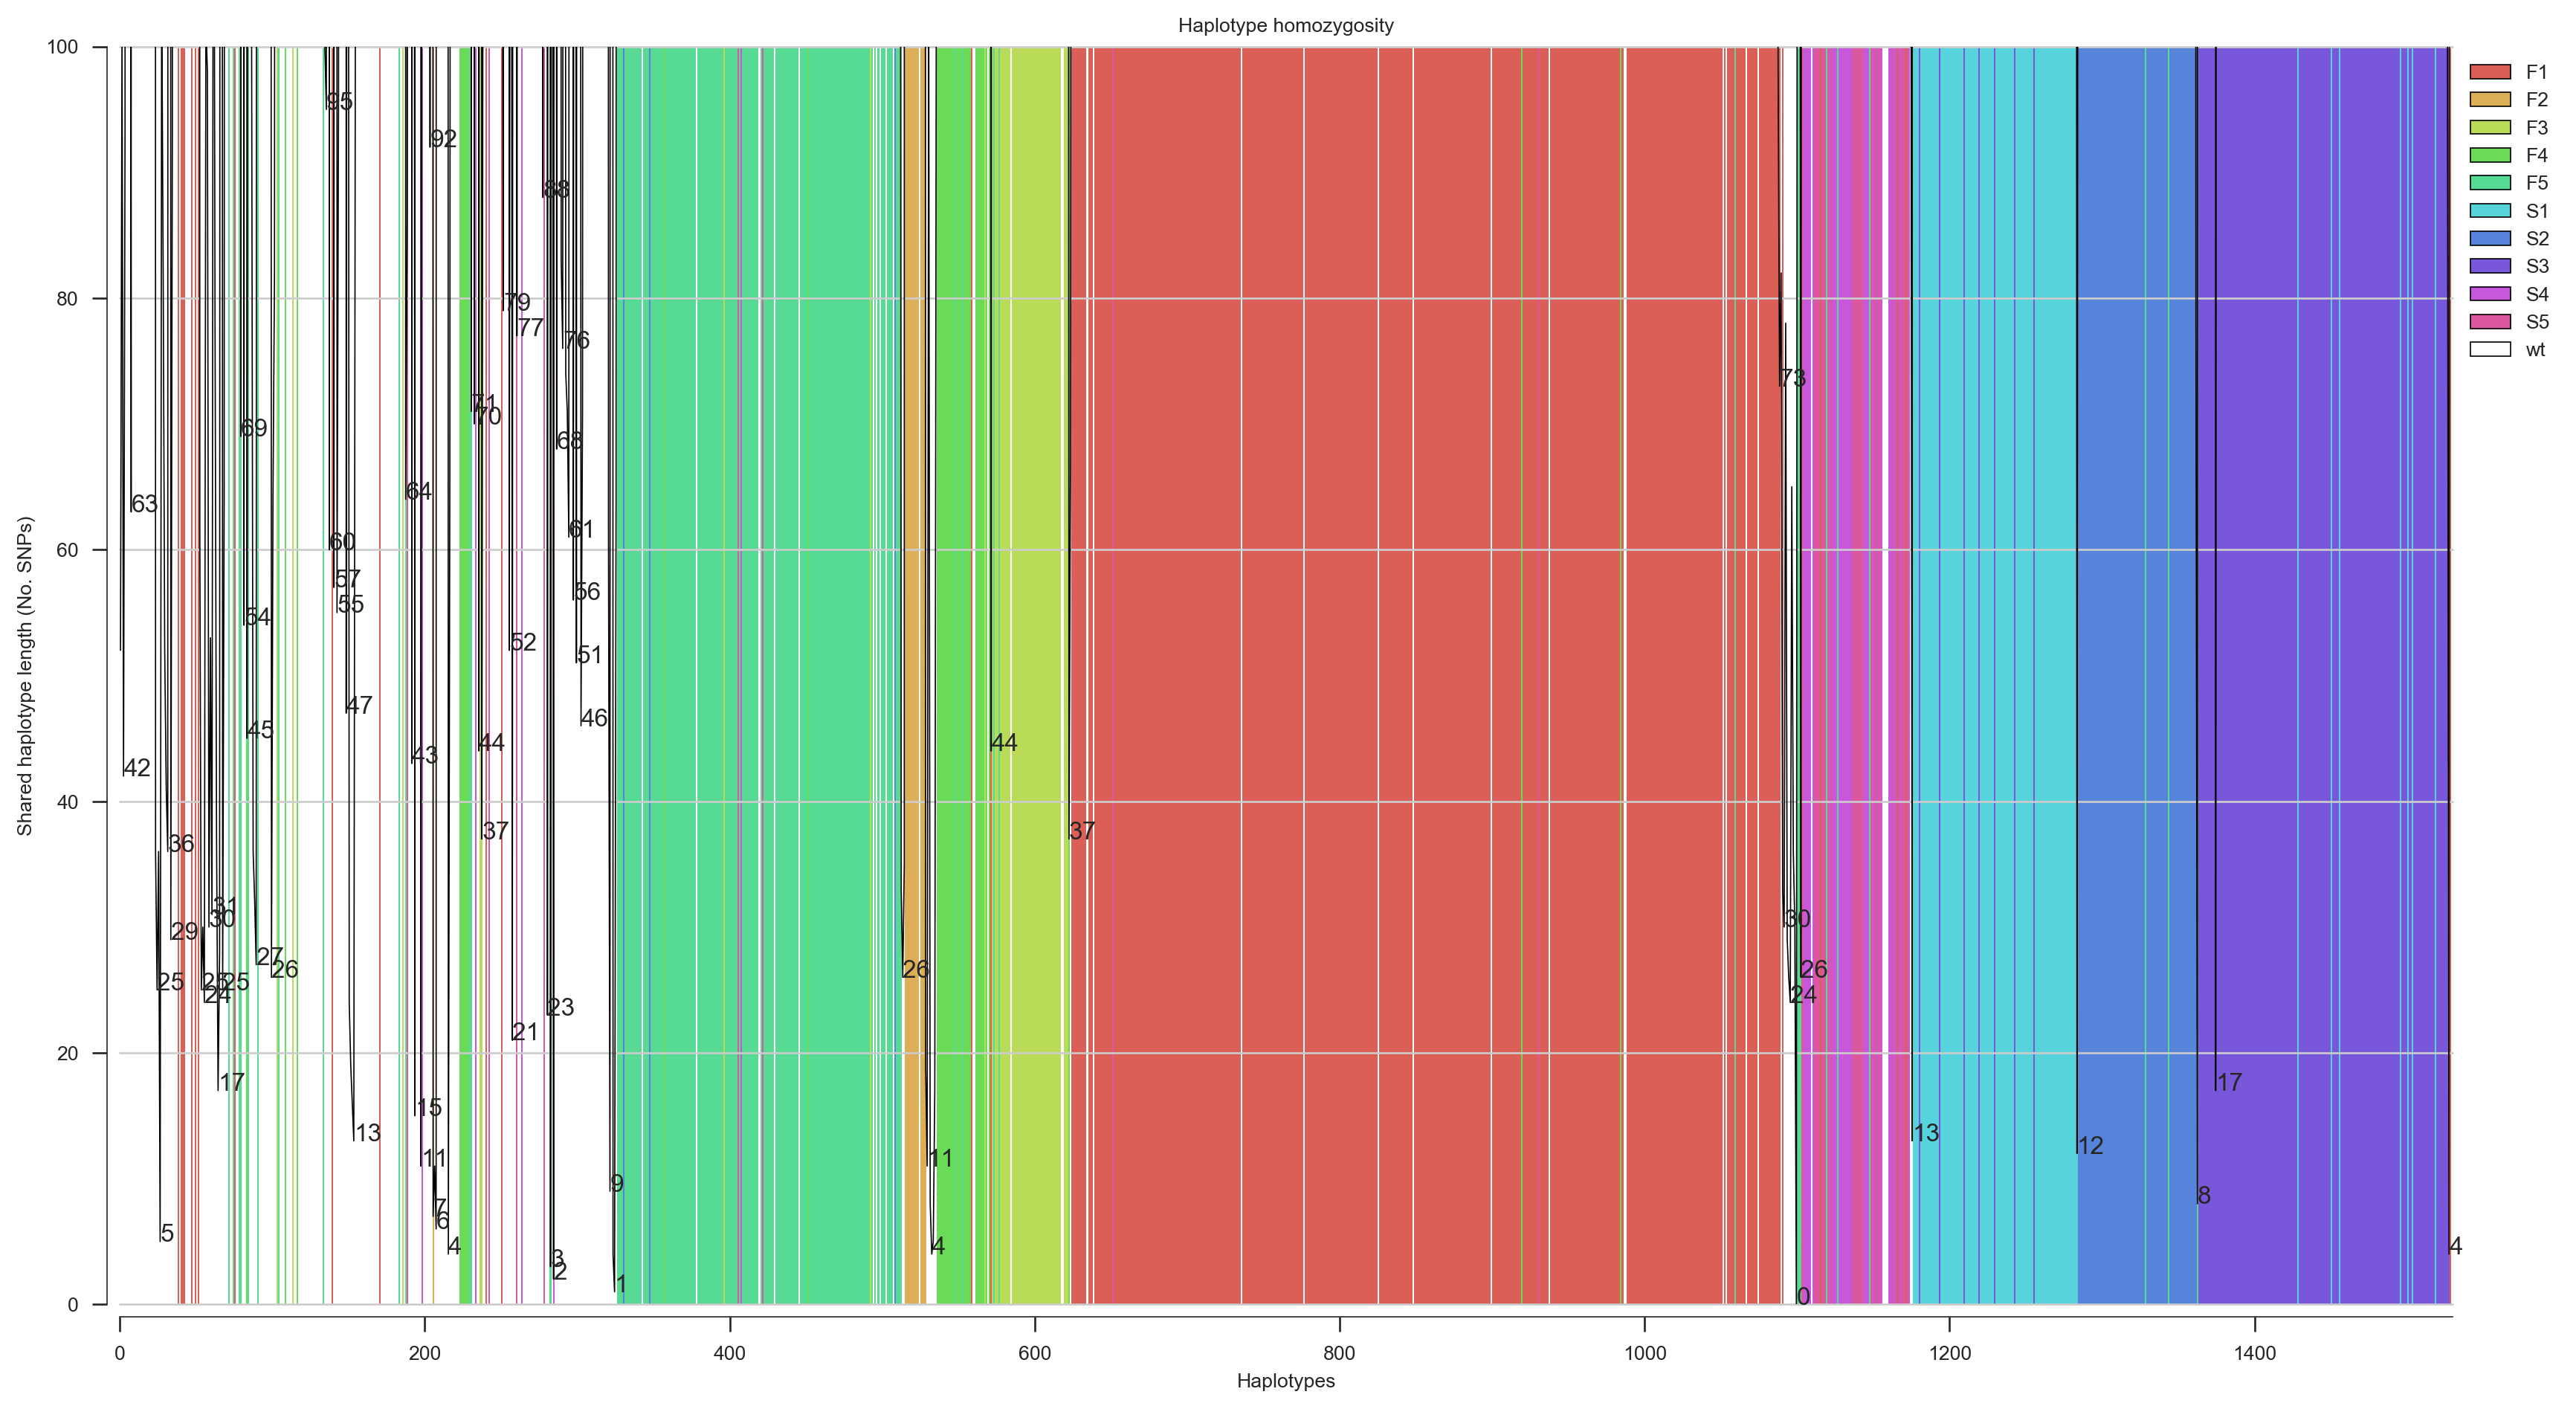

In [32]:
h = haps_right
pos = pos_right
analyze_haplotype_sharing(h, pos, spd_cut=10000, no_snps=100)

wt 14/337 (4.2%) [('wt', 14)]
wt 11/337 (3.3%) [('wt', 11), ('F1', 7)]
wt 11/337 (3.3%) [('wt', 11), ('F3', 1)]
wt 16/337 (4.7%) [('wt', 16), ('F5', 1), ('S5', 1), ('S4', 1)]
wt 13/337 (3.9%) [('wt', 13)]
S1 92/108 (85.2%) [('S1', 92), ('S3', 7)]
S5 26/36 (72.2%) [('S5', 26), ('wt', 3), ('F1', 3), ('F5', 2), ('S4', 2)]
S3 143/165 (86.7%) [('S3', 143), ('S1', 7)]
S3 15/165 (9.1%) [('S3', 15)]
S4 30/37 (81.1%) [('S4', 30), ('wt', 4), ('S5', 2), ('F5', 1)]
S2 76/79 (96.2%) [('S2', 76), ('F5', 3)]
F2 12/14 (85.7%) [('F2', 12), ('wt', 1)]
F5 165/194 (85.1%) [('F5', 165), ('wt', 12), ('F3', 2), ('S5', 2), ('S2', 2), ('F4', 2), ('S4', 1)]
F3 45/53 (84.9%) [('F3', 45), ('wt', 3), ('F5', 2), ('F4', 1)]
F4 26/42 (61.9%) [('F4', 26), ('F5', 2), ('wt', 2), ('F1', 2)]
F1 444/465 (95.5%) [('F1', 444), ('wt', 14), ('S5', 2), ('F4', 2), ('F5', 1)]


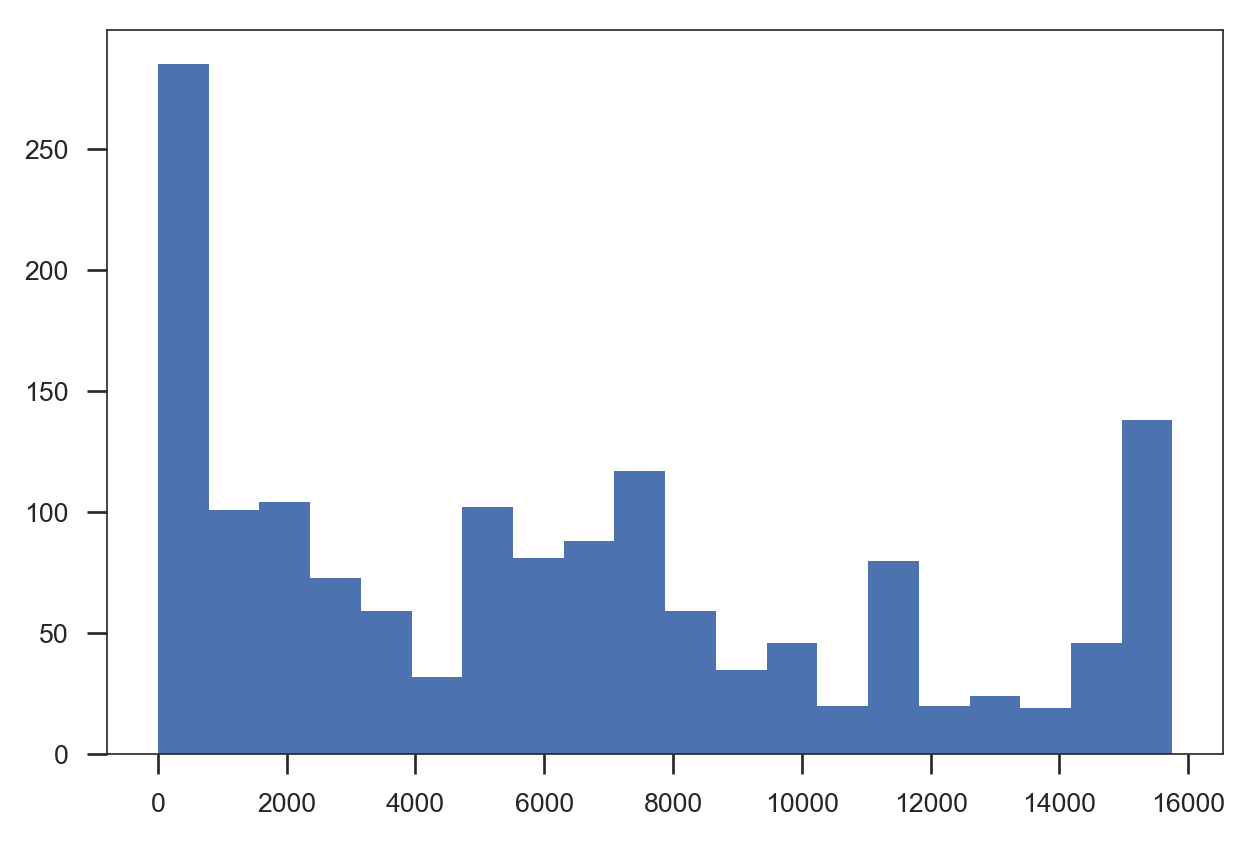

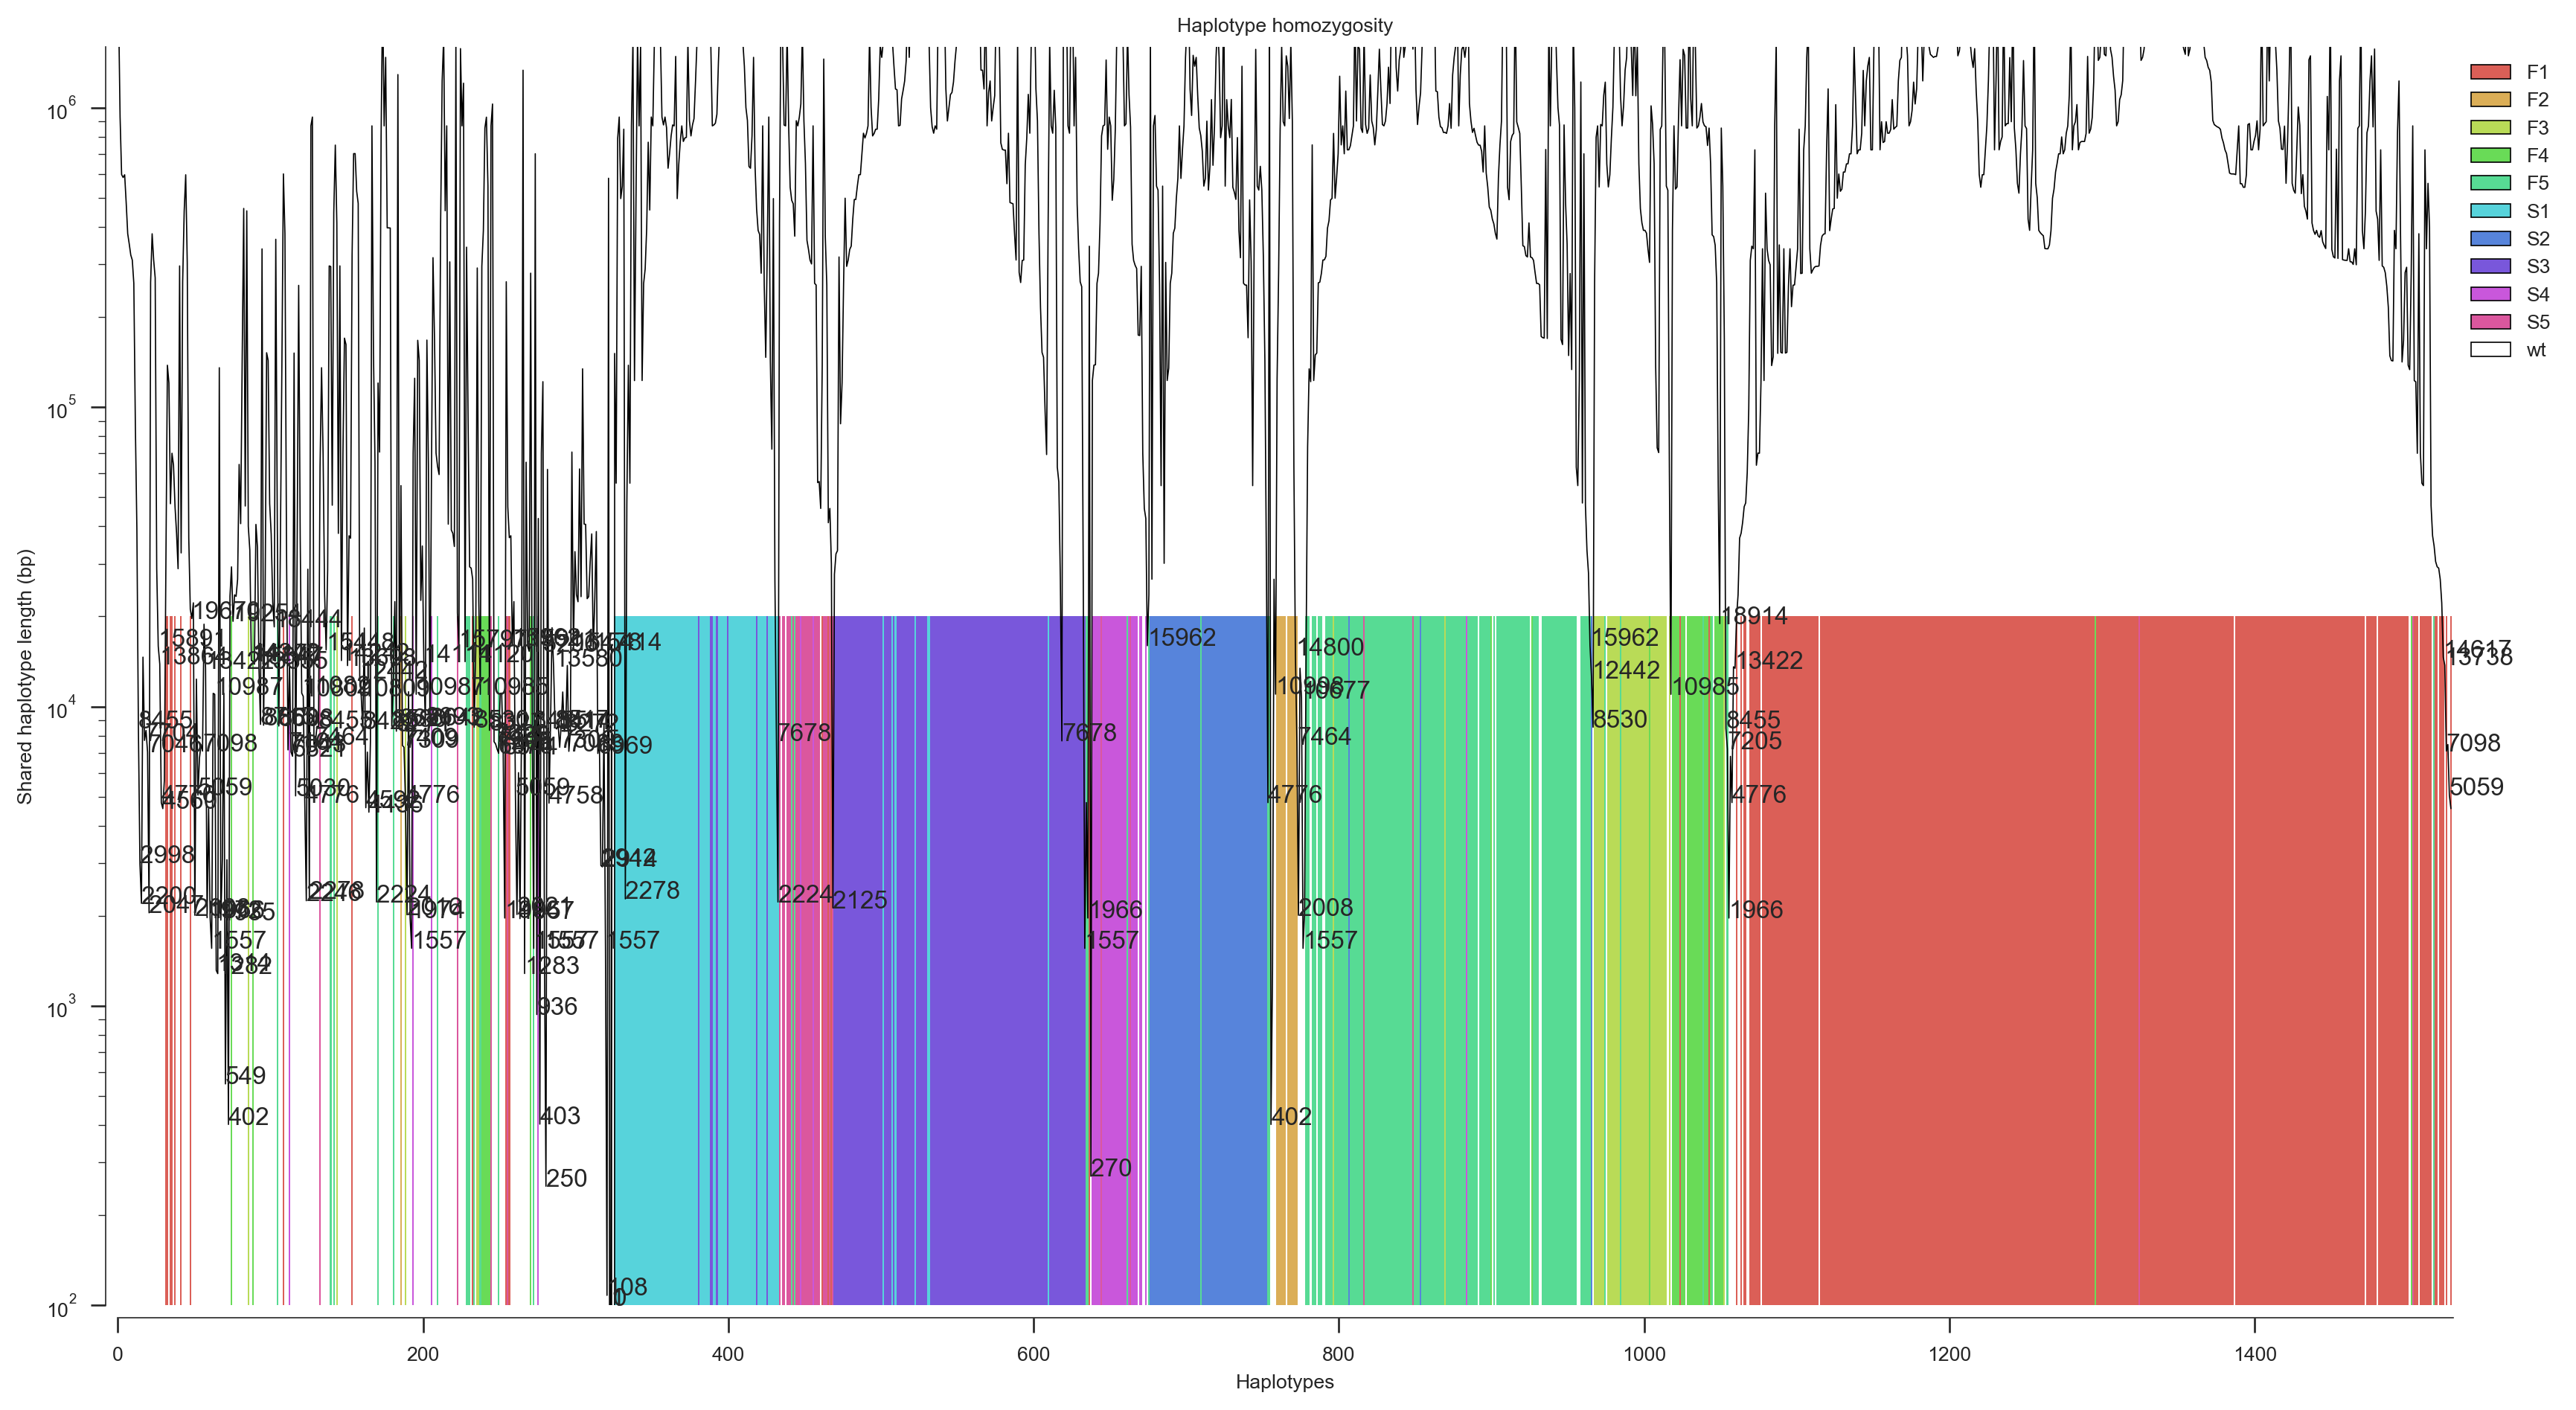

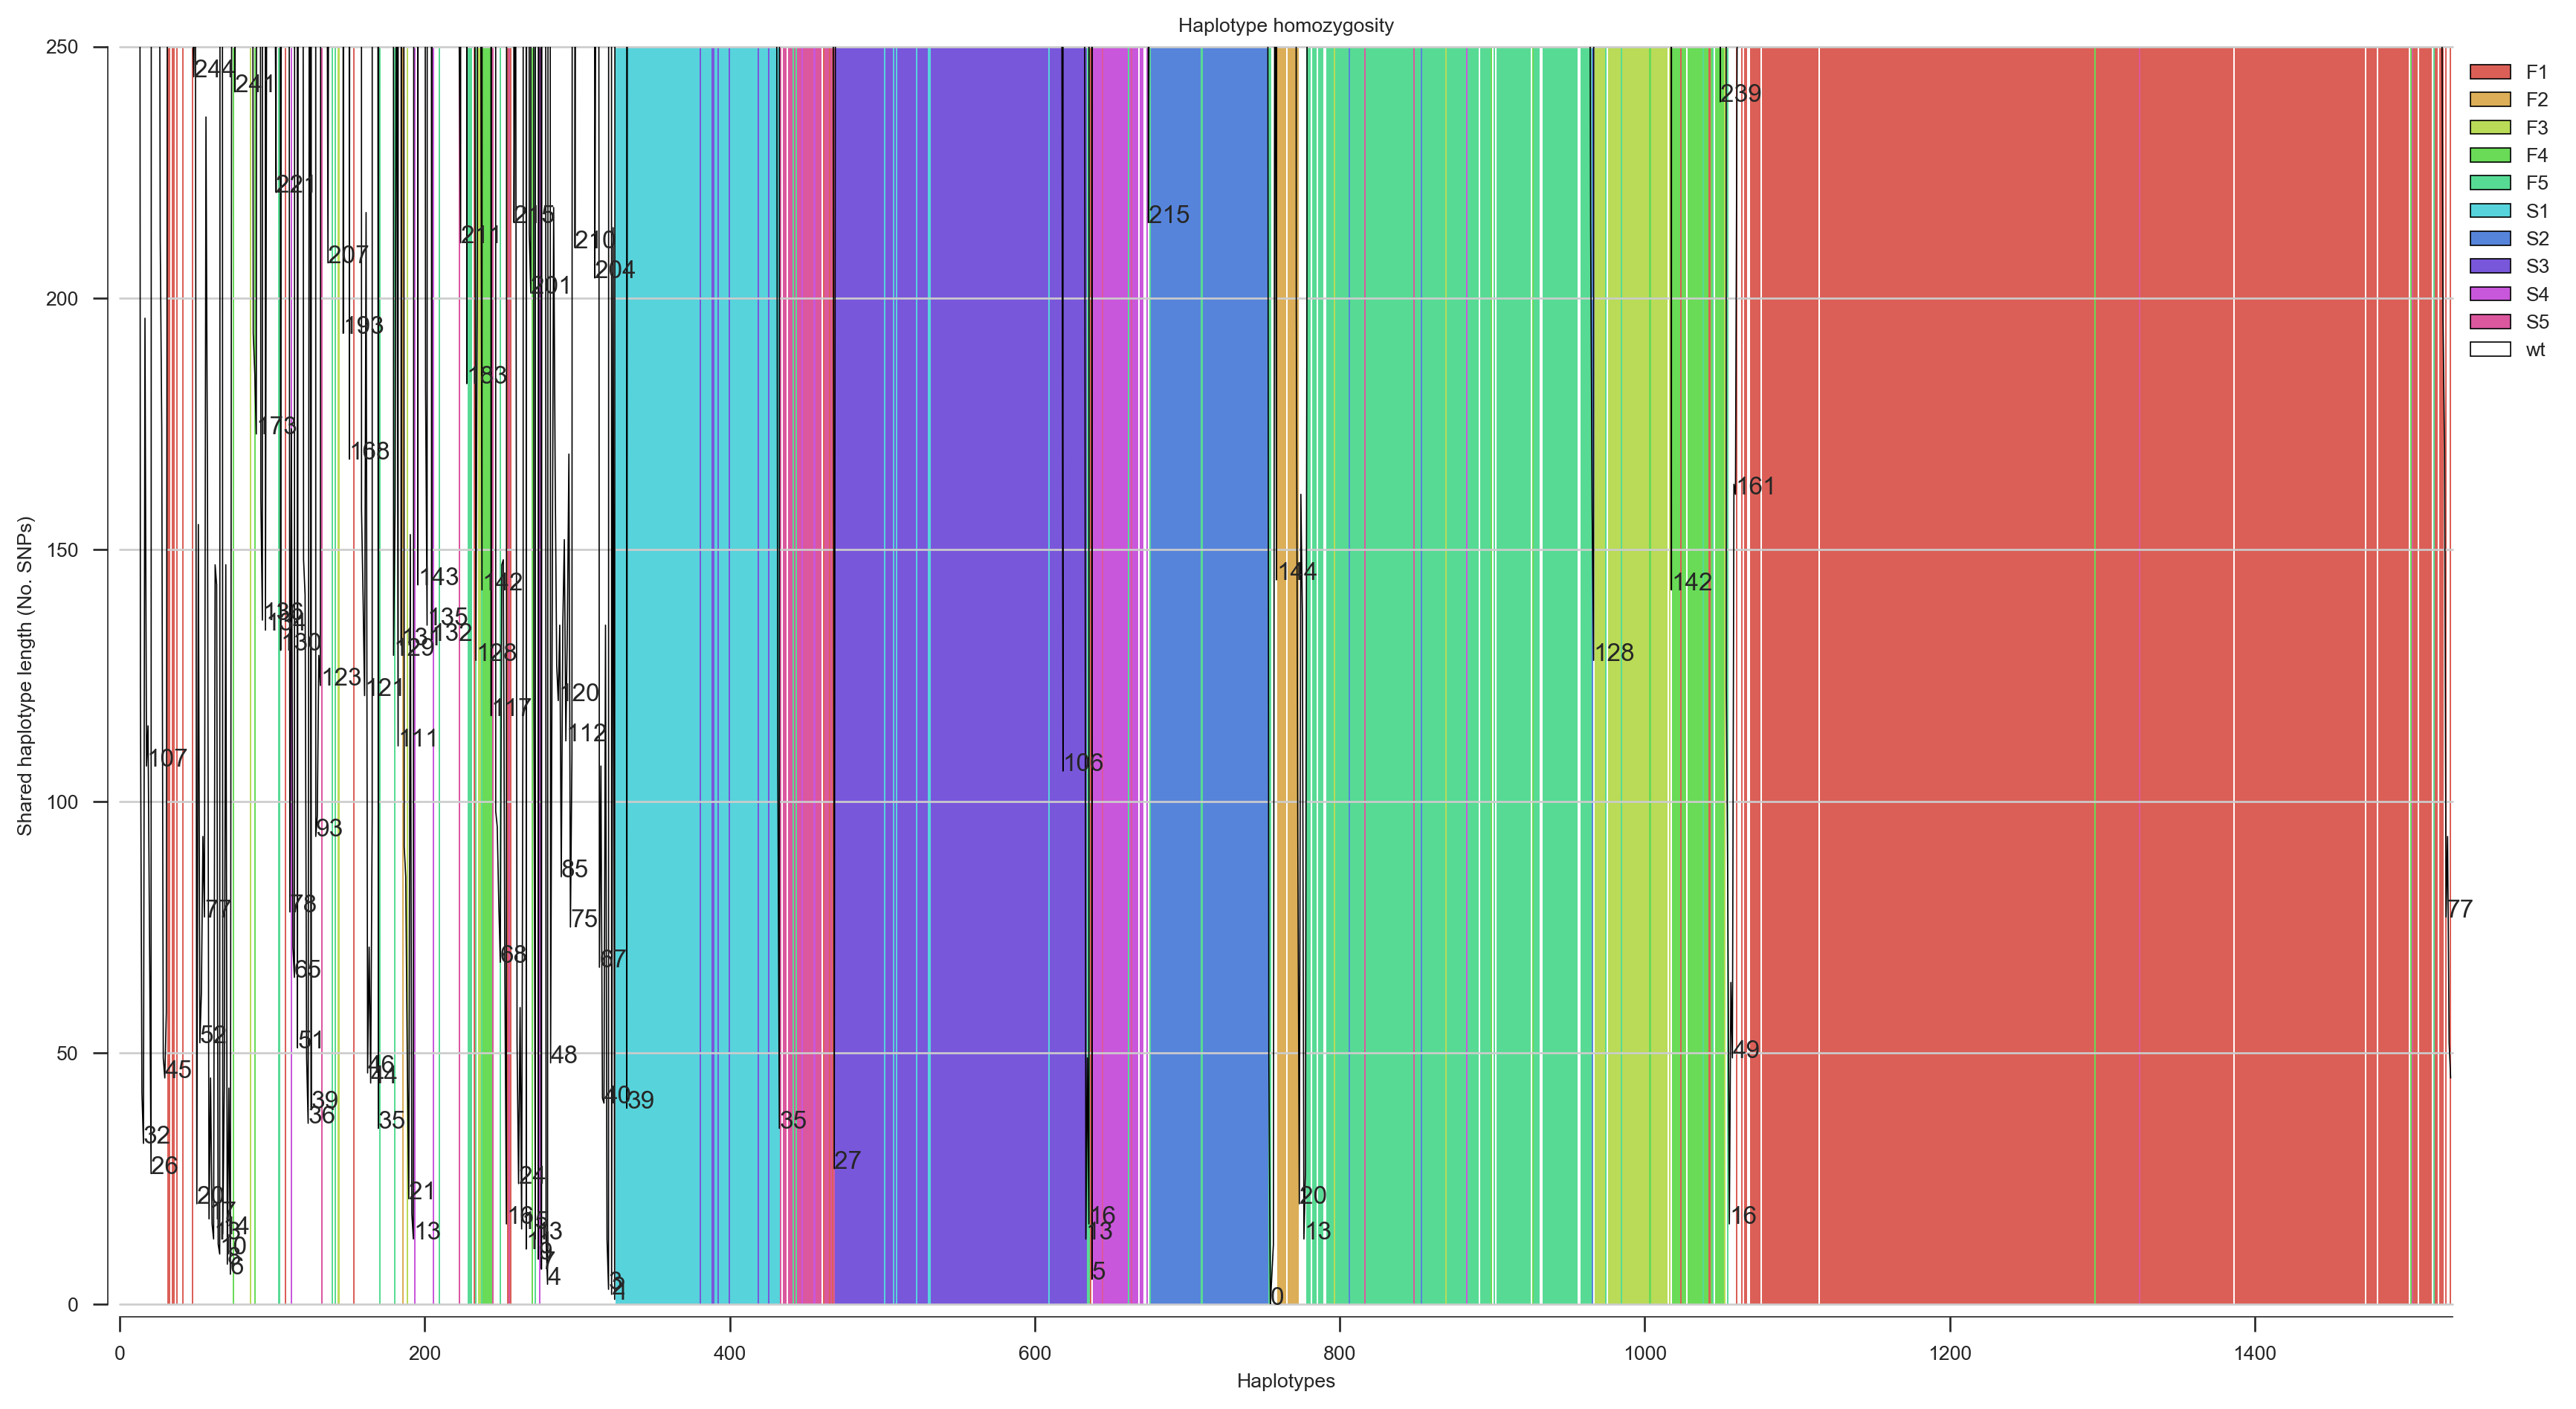

In [33]:
h = haps_left[::-1]
pos = np.asarray(pos_left)[::-1]
analyze_haplotype_sharing(h, pos, spd_cut=20000, no_snps=250)

In [34]:
def ehh_decay(h, truncate=False):
    """Compute the decay of extended haplotype homozygosity (EHH)
    moving away from the first variant.

    Parameters
    ----------
    h : array_like, int, shape (n_variants, n_haplotypes)
        Haplotype array.
    truncate : bool, optional
        If True, the return array will exclude trailing zeros.

    Returns
    -------
    ehh : ndarray, float, shape (n_variants, )
        EHH at successive variants from the first variant.

    """

    # check inputs
    h = allel.HaplotypeArray(h, dtype='i1', copy=False)
    if h.max() > 1:
        raise NotImplementedError('only biallelic variants are supported')
    if h.min() < 0:
        raise NotImplementedError('missing calls are not supported')

    # initialise
    n_variants = h.n_variants  # number of rows, i.e., variants
    n_haplotypes = h.n_haplotypes  # number of columns, i.e., haplotypes
    n_pairs = (n_haplotypes * (n_haplotypes - 1)) // 2

    # compute the shared prefix length between all pairs of haplotypes
    spl = allel.opt.stats.pairwise_shared_prefix_lengths(np.asarray(h))

    # compute EHH by counting the number of shared prefixes extending beyond
    # each variant
    minlength = None if truncate else n_variants + 1
    b = np.bincount(spl, minlength=minlength)
    c = np.cumsum(b[::-1])[:-1]
    ehh = (c / n_pairs)[::-1]

    return ehh

In [35]:
cm_count = collections.Counter(cluster_membership)
cm_count

Counter({'F1': 465,
         'F2': 14,
         'F3': 53,
         'F4': 42,
         'F5': 194,
         'S1': 108,
         'S2': 79,
         'S3': 165,
         'S4': 37,
         'S5': 36,
         'wt': 337})

In [36]:
pop_colors = phase1_ar3.pop_colors
pop_labels = phase1_ar3.pop_labels

In [37]:
populations = phase1_ar3.pop_ids
populations

('AOM', 'BFM', 'GWA', 'GNS', 'BFS', 'CMS', 'GAS', 'UGS', 'KES')

In [38]:
def analyse_ehh(left_flank, right_flank, min_count, flank_size=1000000, 
                ax=None, debug=True, kdr_lw=1, wt_lw=1, output_fn_stem=None):

    loc_core = slice(idx_995S_ehh-left_flank, idx_995F_ehh+right_flank+1)
    left_pos = pos_ehh[idx_995S_ehh-left_flank]
    right_pos = pos_ehh[idx_995F_ehh+right_flank]
    if debug: print(left_pos, right_pos, right_pos - left_pos + 1)
#     print(pos_ehh[loc_core])
    pos_core = pos_ehh[loc_core]
    ref_core = ref_ehh[loc_core].astype('U')
    alt_core = alt_ehh[loc_core].astype('U')
    h = haps_ehh[loc_core]
    h.shape
    d = h.distinct()
    if debug: print(h.shape[0], 'SNPs', len(d), 'distinct haplotypes')

    # right flank
    loc = pos_right.locate_range(2422652, 2422652 + flank_size)
    pr = pos_right[loc]
    hr = haps_right[loc]

    # left flank
    loc = pos_left.locate_range(2422651 - flank_size, 2422651)
    pl = pos_left[loc]
    hl = haps_left[loc]

    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 3))
        sns.despine(ax=ax, offset=5)
        
    out = dict()
    
    # setup core haplotypes dataframe
    df_core = pandas.DataFrame.from_items([('Position', pos_core), ('REF', ref_core), ('ALT', alt_core)])
    tbl_summ = [['Haplotype', 'IHH', 'Frequency'] + [pop_labels[p].replace('$', '') for p in populations]]

    idx_l = 1  # labelling of L995 core haplotypes
    for i, s in enumerate(d):
        if len(s) >= min_count:
            if debug: print()
            sc = collections.Counter(cluster_membership[list(s)]).most_common()
            c = sc[0][0]
            overlap = len(cluster_indices[c].intersection(s))
            n = len(cluster_indices[c])
            if debug: print(i, len(s), ''.join(map(str, (h[:, list(s)[0]]))))
            if debug: print('%s %s/%s (%.1f%%)' % (c, overlap, n, overlap * 100 / n))
            kdr_f = haps_ehh[idx_995F_ehh, list(s)[0]] == 1
            kdr_s = haps_ehh[idx_995S_ehh, list(s)[0]] == 1
            sm_count = collections.Counter(cluster_membership[list(s)])
            if debug: print(', '.join(['%s:%s/%s' % (k, c, cm_count[k]) if k else 'wt:%s' % c for k, c in sm_count.most_common()]))
            pop_count = collections.Counter(df_haplotypes.population[list(s)])
            if debug: print(pop_count)
            edcr = ehh_decay(hr.take(list(s), axis=1))
            edcl = ehh_decay(hl.take(list(s), axis=1)[::-1])[::-1]
            allele = 'F' if kdr_f else 'S' if kdr_s else 'L'
            ihh = np.trapz(edcr, pr) + np.trapz(edcl, pl)
            if debug: print('995', allele, 'IHH', ihh)
            if kdr_f or kdr_s:
                clst = sm_count.most_common()[0][0]
                out[clst] = s 
                label = clst
                color = kdr_colors[clst]
                lw = kdr_lw
                linestyle = '-'
                # add haplotype to core table
                df_core[clst] = h[:, list(s)[0]]
            else:
                clst = 'L%s' % idx_l
                out[clst] = s 
                idx_l += 1
                pop = pop_count.most_common()[0][0]
                color = pop_colors[pop]
                lw = wt_lw
                label = None
                linestyle = '--'
                # add haplotype to core table
                df_core[clst] = h[:, list(s)[0]]
            # add to summary table
            row = [clst, int(ihh), len(s)] + [pop_count.get(p, 0) for p in populations]
            tbl_summ += [row]
            ax.plot(pr, edcr, color=color, lw=lw, label=label, linestyle=linestyle)
            ax.plot(pl, edcl, color=color, lw=lw, linestyle=linestyle)
    ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
    if output_fn_stem:
        df_core = df_core['Position REF ALT F1 F2 F3 F4 F5 S1 S2 S3 S4 S5'.split() + ['L%s' % j for j in range(1, idx_l)]]
        df_core.to_csv(output_fn_stem + '_haps.csv', index=False)
        etl.wrap(tbl_summ).tocsv(output_fn_stem + '_summ.csv')
    return out

2422250 2423671 1422
18 SNPs 25 distinct haplotypes

0 566 000001001100000000
F1 449/465 (96.6%)
F1:449/465, F3:46/53, wt:33/337, F4:31/42, F5:5/194, S5:2/36
Counter({'BFS': 162, 'BFM': 117, 'CMS': 107, 'AOM': 102, 'GNS': 62, 'GAS': 16})
995 F IHH 367652.670149

1 205 000001000100000000
F5 167/194 (86.1%)
F5:167/194, wt:15/337, F2:13/14, S2:3/79, F3:2/53, S5:2/36, F4:2/42, S4:1/37
Counter({'CMS': 181, 'GAS': 24})
995 F IHH 549207.929914

2 165 000010000100100000
S3 158/165 (95.8%)
S3:158/165, S1:7/108
Counter({'UGS': 98, 'KES': 67})
995 S IHH 625394.995639

3 125 000000000100000000
wt 103/337 (30.6%)
wt:103/337, F1:9/465, F5:8/194, F4:3/42, F3:2/53
Counter({'CMS': 75, 'BFM': 21, 'GWA': 16, 'AOM': 13})
995 L IHH 16874.5924516

4 108 000010000100000001
S1 101/108 (93.5%)
S1:101/108, S3:7/165
Counter({'UGS': 108})
995 S IHH 819768.738837

5 79 100010000100000010
S2 76/79 (96.2%)
S2:76/79, F5:3/194
Counter({'GAS': 71, 'CMS': 8})
995 S IHH 537828.734989

6 67 000000001100000000
wt 49/337 (1

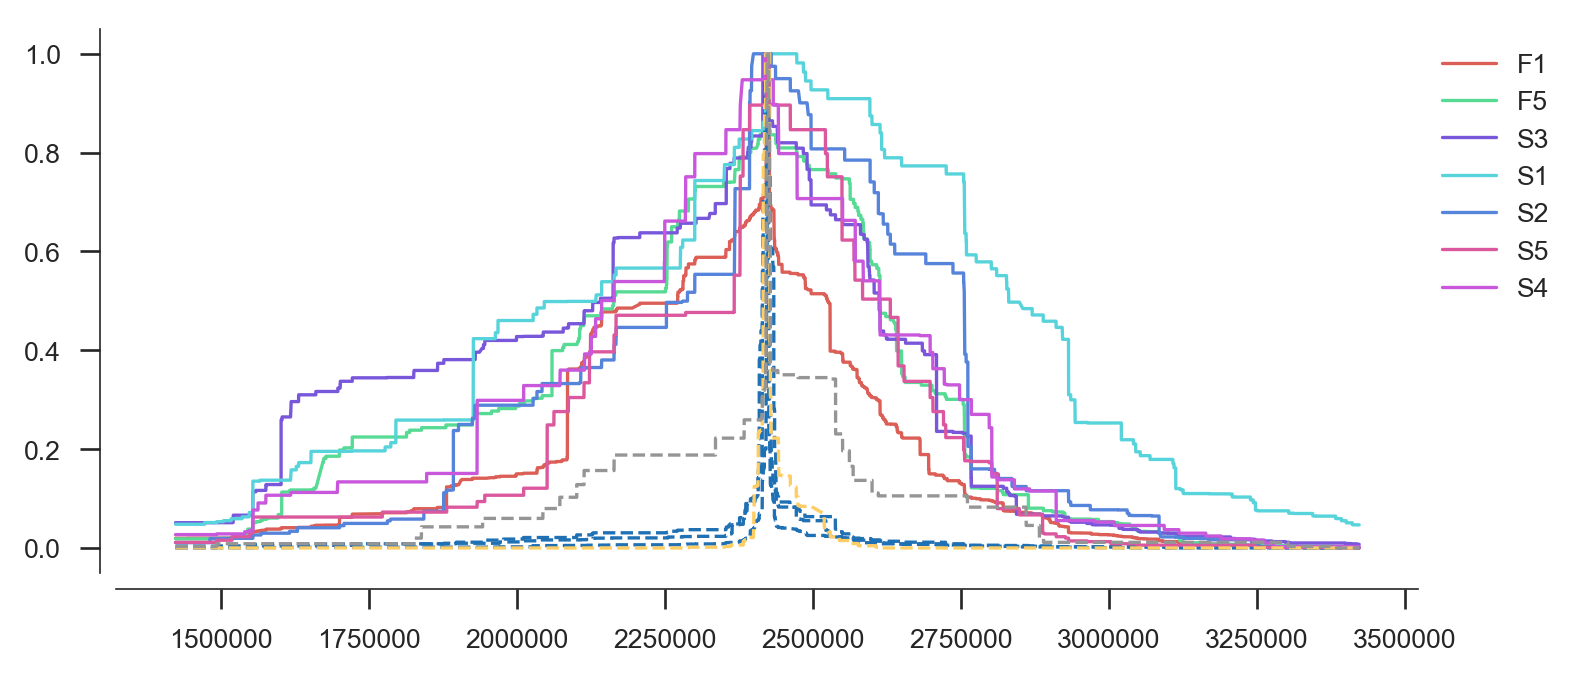

In [39]:
# to distinguish S haplotypes
analyse_ehh(left_flank=4, right_flank=12, min_count=13);

2422250 2426521 4272
49 SNPs 70 distinct haplotypes

0 468 0000010011000000001001000000010000000000010000000
F1 447/465 (96.1%)
F1:447/465, wt:16/337, S5:2/36, F4:2/42, F5:1/194
Counter({'BFS': 162, 'BFM': 116, 'AOM': 94, 'GNS': 62, 'CMS': 34})
995 F IHH 523012.650167

1 188 0000010001000000001001000000010000000000000000000
F5 167/194 (86.1%)
F5:167/194, wt:11/337, S2:3/79, F3:2/53, S5:2/36, F4:2/42, S4:1/37
Counter({'CMS': 164, 'GAS': 24})
995 F IHH 648911.674935

2 153 0000100001001000001001000000011000000000000000000
S3 146/165 (88.5%)
S3:146/165, S1:7/108
Counter({'UGS': 98, 'KES': 55})
995 S IHH 650208.235294

3 108 0000100001000000011001000000000000000000001000000
S1 101/108 (93.5%)
S1:101/108, S3:7/165
Counter({'UGS': 108})
995 S IHH 819768.738837

4 79 1000100001000000101001000000010000000010000000000
S2 76/79 (96.2%)
S2:76/79, F5:3/194
Counter({'GAS': 71, 'CMS': 8})
995 S IHH 537828.734989

5 51 0000010011000000001001000000010000000000000000001
F3 45/53 (84.9%)
F3:45/53, wt:3/

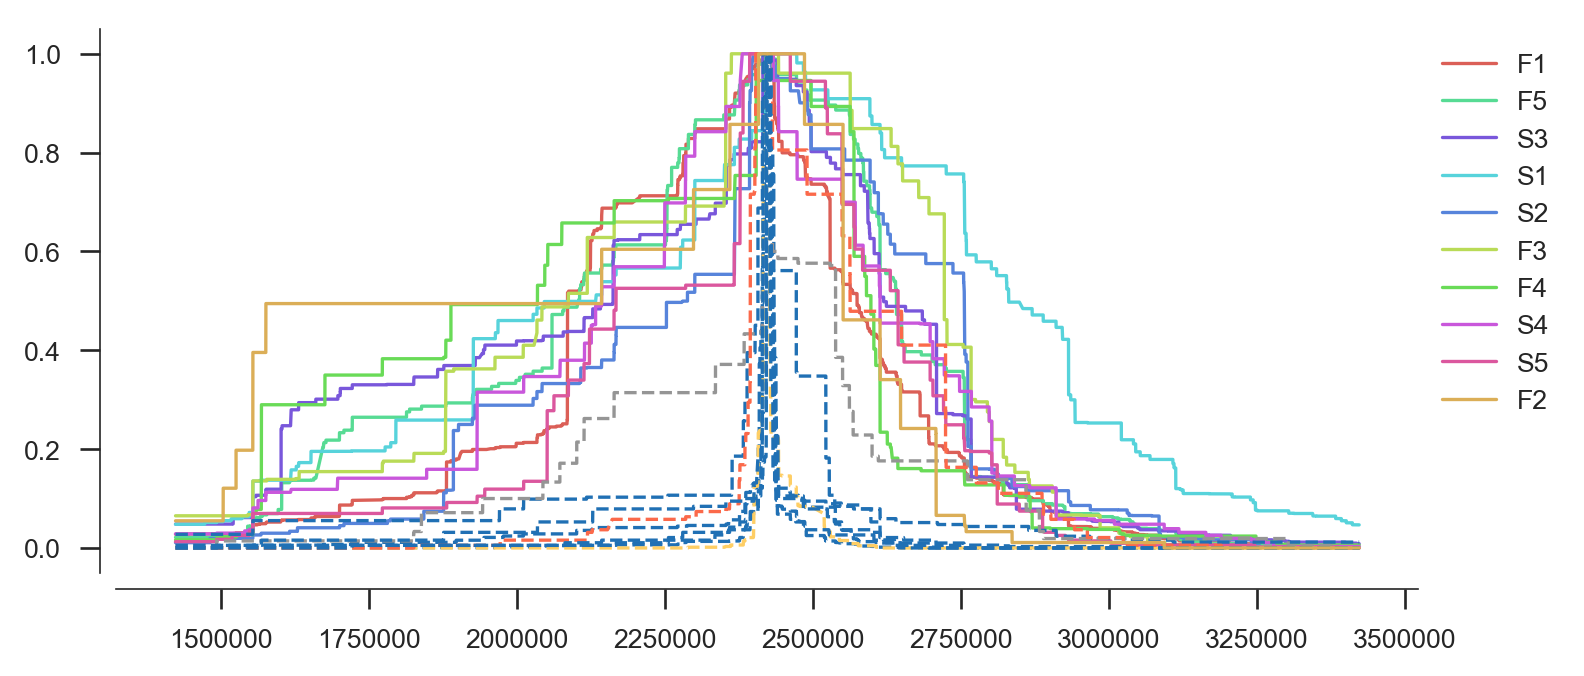

In [40]:
# to distinguish F haplotypes 
analyse_ehh(left_flank=4, right_flank=43, min_count=13, output_fn_stem='../data/vgsc_core');